In [6]:
import cv2
import matplotlib.pyplot as plt
import random
from PIL import Image
import array
from cmath import sqrt,  atan
import random
import queue
import sys
import time
from google.colab.patches import cv2_imshow

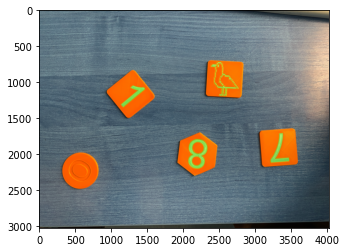

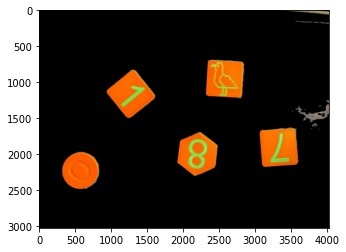

In [9]:
img = cv2.imread("/content/drive/MyDrive/7-term/ЦОСиИ/Lab2/IMG_7240.JPG")
plt.imshow(img)
plt.show()

dim = (680, 680)
img_res = cv2.resize(img, dim)


r1 = 0
g1 = 114
b1 = 85
r2 = 120
g2 = 255
b2 = 248
blur = 3

min_p = (g1,b1,r1)
max_p = (g2,b2,r2)
img_bl = cv2.medianBlur(img_res, 1+blur*2) # сглаживание изображения
img_mask = cv2.inRange(img_bl, min_p, max_p)
dim = (img.shape[1], img.shape[0])
img_mask = cv2.resize(img_mask, dim)
img_m = cv2.bitwise_and(img, img, mask = img_mask)
cv2.imwrite("your_file.jpeg", img_m)

plt.imshow(img_m)
plt.show()


In [10]:
def select_medoid(cluster):
    """
    :type cluster: list
    """
    distances_sum = []
    for blob in cluster:
        distances = [blob.distance(el) for el in filter(lambda x: x is not blob, cluster)]
        distances_sum.append(sum(distances))
    medoid_idx = distances_sum.index(min(distances_sum))

    return cluster[medoid_idx]


# Split array of blobs to k clusters
def kmedoids(blobs, k, iterations = 1000):
    """
    :type blobs: list
    """
    # select random blobs for each cluster
    centers = random.sample(blobs, k)
    clusters = []
    for i in range(iterations):
        # set list of cluster and fill it with empty lists
        clusters = [[] for i in range(k)]
        for blob in blobs:
            distances = [center.distance(blob) for center in centers]
            # select cluster by min distance
            cluster_id = distances.index(min(distances))
            clusters[cluster_id].append(blob)
        # select new cluster medoids
        centers = [select_medoid(cluster) for cluster in clusters]

    return clusters

In [11]:
def binarize(gray_img, threshold=128):
    """
    :type gray_img: Image.Image
    :return: Image.Image
    """
    data = list(gray_img.getdata())
    for i in range(len(data)):
        data[i] = max(0, min(1, data[i]-threshold))*255
    bin_img = Image.new('L', gray_img.size)
    bin_img.putdata(data)

    return bin_img


## take a PIL rgb image and produce a factory that yields
## ((x, y), (r, g, b)), where (x, y) are the coordinates
## of a pixel, (x, y), and its RGB values.
def gen_pix_factory(im):
    num_cols, num_rows = im.size
    row, col = 0, 0
    while row != num_rows:
        col = col % num_cols
        yield ((col, row), im.getpixel((col, row)))
        if col == num_cols - 1:
            row += 1
        col += 1


## luminance conversion formula from
## http://en.wikipedia.org/wiki/Luminance_(relative)
## recommendations from
## http://www.efg2.com/Lab/Library/UseNet/2001/0623.txt
def luminosity_smpte_295m(rgb, rcoeff=0.2126, gcoeff=0.7152, bcoeff=0.0722):
    return rcoeff*rgb[0]+gcoeff*rgb[1]+bcoeff*rgb[2]



## take a PIL RBG image and a luminosity conversion formula,
## and return a new gray level PIL image in which
## each pixel is obtained by applying the luminosity formula
## to the corresponding pixel in the RGB image.
def rgb_to_gray(rgb_img, conversion=luminosity_smpte_295m):
    gl_img = Image.new('L', rgb_img.size)
    gen_pix = gen_pix_factory(rgb_img)
    lum_pix = ((gp[0], conversion(gp[1])) for gp in gen_pix)
    for lp in lum_pix:
        gl_img.putpixel(lp[0], int(lp[1]))
    return gl_img

In [13]:
class ConnectedComponent(object):
    def __init__(self, label_id):
        """
        :type label_id: integer
        """
        self.id = label_id
        self.points = []
        self.perimeter = 0
        self.area = 0
        self.mass_center = (0, 0)
        self.m20 = 0
        self.m02 = 0
        self.m11 = 0
        #self.density = 0
        self.elongation = 0
        self.orientation = 0
        self.__is_done = False

    # draw connected component on canvas
    def draw(self, canvas, color):
        """
        :type canvas: Image.Image
        """
        for x, y in self.points:
            try:
                canvas.putpixel((x, y), color)
            except IndexError as e:
                pass

        return canvas

    # get boundary box for object
    def boundary_box(self):
        # find box corners
        xs = [point[0] for point in self.points]
        ys = [point[1] for point in self.points]

        # return box properties
        return min(xs), min(ys), max(xs), max(ys)

    # This is internal method
    # that finishes calculation of params
    def done(self):
        if not self.__is_done:
            self.__is_done = True
            self.area = float(len(self.points))
            #self.density = pow(self.perimeter, 2) / self.area
            # Center of mass
            mx, my = 0, 0
            for x, y in self.points:
                mx += x
                my += y
            self.mass_center = (mx/self.area, my/self.area)
            # Discrete central moments
            for x, y in self.points:
                self.m20 += pow(x - self.mass_center[0], 2)
                self.m02 += pow(y - self.mass_center[1], 2)
                self.m11 += (x - self.mass_center[0]) * (y - self.mass_center[1])
            ## elongation
            m20, m02, m11 = self.m20, self.m02, self.m11
            d1, d2 = m20+m02, abs(sqrt(pow(m20-m02, 2) + 4.0*pow(m11, 2)))
            # todo: fix calculations?
            try:
                self.elongation = (d1 + d2) / (d1 - d2)
                # orientation
                self.orientation = atan(2*m11 / (m20 - m02)) / 2
            except ZeroDivisionError as e:
                pass
        else:
            raise StandardError("You can't change state of an connected component")

    def distance(self, obj):
        area_diff = abs(self.area - obj.area)
        perimetr_diff = abs(self.perimeter - obj.perimeter)
        #density_diff = abs(self.density - obj.density)
        elong_diff = abs(self.elongation - obj.elongation)
    
        dist = 0
        dist = sqrt(pow(dist, 2) + pow(area_diff, 2))
        dist = sqrt (pow (dist,2)	+ pow(perimetr_diff,2))
        #dist = sqrt(pow(dist, 2) + pow(density_diff, 2))
        dist = sqrt(pow(dist, 2) + pow(elong_diff, 2))

        return abs(dist)


def select_label(used):
    """
    :type used: set
    :return: int
    """
    prev = 0
    for label in used:
        if label-1 is not prev:
            used.add(prev+1)
            return prev+1
        else:
            prev = label
    if prev+1 not in used:
        used.add(prev+1)
    return prev+1


def __labeling_step(img_data, labels, current_label, point, size, q):
    """
    :type img_data: list
    :type labels: array.array
    :type current_label: ConnectedComponent
    :type point: integer
    :type size: tuple
    :type q: Queue.Queue
    """
    # prepare all params of object
    width, height = size
    col, row = point % width, int(point / height) + 1

    if img_data[point] is 0 or labels[point] is not 0:
        return False

    # todo: border is wrong! Fix it!
    border = 0
    labels[point] = current_label.id
    if col > 0:
        border += img_data[point-1] is 0 or labels[point-1] is not 0
        q.put(point-1)
    if col < width - 1:
        border += img_data[point+1] is 0 or labels[point+1] is not 0
        q.put(point+1)
    if row > 0:
        border += img_data[point-width] is 0 or labels[point-width] is not 0
        q.put(point-width)
    if row < height - 1:
        border += img_data[point+width] is 0 or labels[point+width] is not 0
        q.put(point+width)

    # we should consider all 8 points to get correct outer border...
    if border < 3:
        current_label.perimeter += 1

    current_label.area += 1
    current_label.points.append((col, row))

    return True


def find_connected_components(bin_img):
    """
    :type bin_img: Image.Image
    :return: ConnectedComponent
    """
    img_data = list(bin_img.getdata())
    labels = array.array('i', (0 for i in range(len(img_data)-1)))
    # simple hash map with all properties
    # of our connected component
    elements = []
    # reduce amount of gaps in id range
    # this is not necessary
    component_ids = set()
    q = queue.Queue()
    for i in range(len(img_data)-1):
        current_label = ConnectedComponent(select_label(component_ids))
        if __labeling_step(img_data, labels, current_label, i, bin_img.size, q):
            # finish calculation of params
            elements.append(current_label)
        #Breadth First Search optimisation
        while not q.empty():
            j = q.get()
            __labeling_step(img_data, labels, current_label, j, bin_img.size, q)
    for element in elements:
        element.done()

    return elements

def random_color():
    return random.randint(20, 255), random.randint(20, 255), random.randint(20, 255)

START

In [15]:
img = Image.open("/content/your_file.jpg")
img